# API Showcase

This jupyter notebook showcases the code as seperate modules. 

- `utilities`
- `simulator`
- `visualiser`

Each of the modules can be imported, e.g. `from module.xx import yy`.

Finally, a webapp module is made to showcase the functionality using Flask.
The webapp including all functionality can be run using 
```shell
source env/bin/activate
python app.py
```

# The `Utilities` module

## utilities.cleanup

A class is created to clean the previous data. In the webapplication the path is given by the application config, but be careful! No going back here. All `.png` and `.html` files are cleared from this folder. This class for now only exists for removing previous simulation results, but can be extended easily.

In [21]:
from utilities.cleanup import Cleaner
import os

# the static path is the path where all of the visualisations are saved. In the webapp, this is webapp/static
static_path = os.path.join(os.getcwd(), 'webapp', 'static')
Cleaner().remove_previous_simulation_results(static_path=static_path)

## utilties.staticdatareader

A class is written to read the static data. 

A `berlin_stops_file` was given that contains all of the input data for the simulator. 

Additionally, the bounds of Berlin can be obtained by finding the polygon that describes the city. I used [polygons openstreetmap](http://polygons.openstreetmap.fr) to find the boundary of *Relation: Berlin (62422)* in a poly file. There are many other ways of obtaining this, but it's an easy sanity check. The data is stored in `data/berlin_bounds.poly`, which I cleaned up a bit (removing redundant spaces etc).

The StaticDataReader module reads the bounds and stops file and stores the result in two instance variables `berlin_stops` and `berlin_bounds`, both GeoDataFrames with coordinate system EPSG:4326.

In [4]:
from utilities.staticdatareader import StaticDataReader
static_data = StaticDataReader(berlin_bounds_file='data/berlin_bounds.poly', 
                                berlin_stops_file='data/berlin_stops.geojson')

In [5]:
static_data.berlin_stops.head(2)

,name,id,geometry
0,S+U Lichtenberg Bhf (Berlin),u33depjmfnxb,POINT (13.4985169632013 52.5101772594929)
1,S Karlshorst Bhf (Berlin),u33deccqj25n,POINT (13.52611587980488 52.48134727965725)


In [6]:
static_data.berlin_bounds.head(2) 

,geometry
0,POINT (13.088345 52.4196325)
1,POINT (13.0902086 52.41355129999999)


## utilities.bounding_box

A module is written to add some properties to a bounding box, such as center, lats, lons, ...

In [22]:
from utilities.bounding_box import BoundingBox
bounding_box = BoundingBox(
    (
        13.34014892578125, 
        52.52791908000258, 
        13.506317138671875, 
        52.562995039558004
    )
)

print(f'Center: {bounding_box.center}')
print(f'Lats: {bounding_box.lats}')
print(f'Lons: {bounding_box.lons}')

Center: (52.54545705978029, 13.423233032226562)
Lats: [52.52791908000258, 52.562995039558004, 52.562995039558004, 52.52791908000258]
Lons: [13.34014892578125, 13.34014892578125, 13.506317138671875, 13.506317138671875]


# The Simulator module

The simulator has multiple functions. Inspecting the output of each can give insights in how the system works. The simulator does not use the bounding box class, so pass the `bounding_box.bounding_box` property of the instance to the constructor.

In [17]:
# number_of_requests is the number of requests to our Ridepooling service to "simulate".
number_of_requests = 6

In [8]:
from simulator.simulator import Simulator

# create an instance of the simulator class. The berlin_stops file was already defined previously.
simulator = Simulator(
    bounding_box = bounding_box.bounding_box,
    path_to_stops = static_data.berlin_stops_file
)

## `simulator.get_booking_distance_bins()`
Performs a division into bins, based on the distribution given by the class variable `booking_distance_distribution`.

This variable is not used to do the sampling on the data so I don't use it either. 

In [25]:
simulator.get_booking_distance_bins(number_of_requests)

{'From 0->1km': 1, 'From 1->2km': 1, 'From 2->3km': 2, 'From 3->4km': 2}

## `simulator.get_random_points()`

Reads the `BERLIN_STOPS` file defined in the flask application config. If this variable does not exist it uses a hardcoded variable. Retrieves points within bounding box and returns the data as a geopandas dataframe, sampled `n` times. The gdf consists of an index, name, id and geometry column.

In [10]:
gdf = simulator.get_random_points(n=number_of_requests)
gdf

,name,id,geometry
330,U Seestr. (Berlin),u336zyd86g2g,POINT (13.35194095173057 52.55041493749874)
2494,"Berlin, Indira-Gandhi-Str./Hansastr.",u33dfmzfsvvn,POINT (13.46910553887043 52.54669517514498)
497,"Berlin, Türkenstr.",u336zxndwu3m,POINT (13.34662021190761 52.55355344954035)
1154,"Berlin, Birkenstr./Rathenower Str.",u336zfer9b2r,POINT (13.35292751715358 52.52967147387569)
2736,"Berlin, Prenzlauer Allee/Danziger Str.",u33dckrq9kk5,POINT (13.42432231400168 52.53913354658323)
2619,"Berlin, Milastr.",u33dcjwfpsfr,POINT (13.41291521584943 52.54523089110715)


The simulator returns a dictionary of three objects.

In [11]:
simulation_results = simulator.simulate(number_of_requests)

print([f"{result}: {type(simulation_results[result])}" for result in simulation_results.keys()])

["booking_distance_bins: <class 'dict'>", "most_popular_dropoff_points: <class 'geopandas.geodataframe.GeoDataFrame'>", "most_popular_pickup_points: <class 'geopandas.geodataframe.GeoDataFrame'>"]


# The Visualiser Module

The `Visualiser` module contains the code to visualise the `Simulator` data. 

There are three visualisation functions:

- A general overview image generated in matplotlib
- A closeup image generated in matlab
- A google maps HTML page using gmplot

First, make an instance of the Visualiser class. PIL is used to visualise images after creation for the use-case of this notebook.

In [12]:
from visualiser.visualiser import Visualiser
from PIL import Image

visualiser = Visualiser(
    bounding_box = bounding_box, 
    simulation_results = simulation_results, 
    static_path = static_path,
    static_data = static_data
)

### `visualiser.generate_overview_figure()`

A general overview image can be generated using the `Visualiser.generate_overview_figure()` function. The figure is stored in the `visualiser.static_path` directory. 

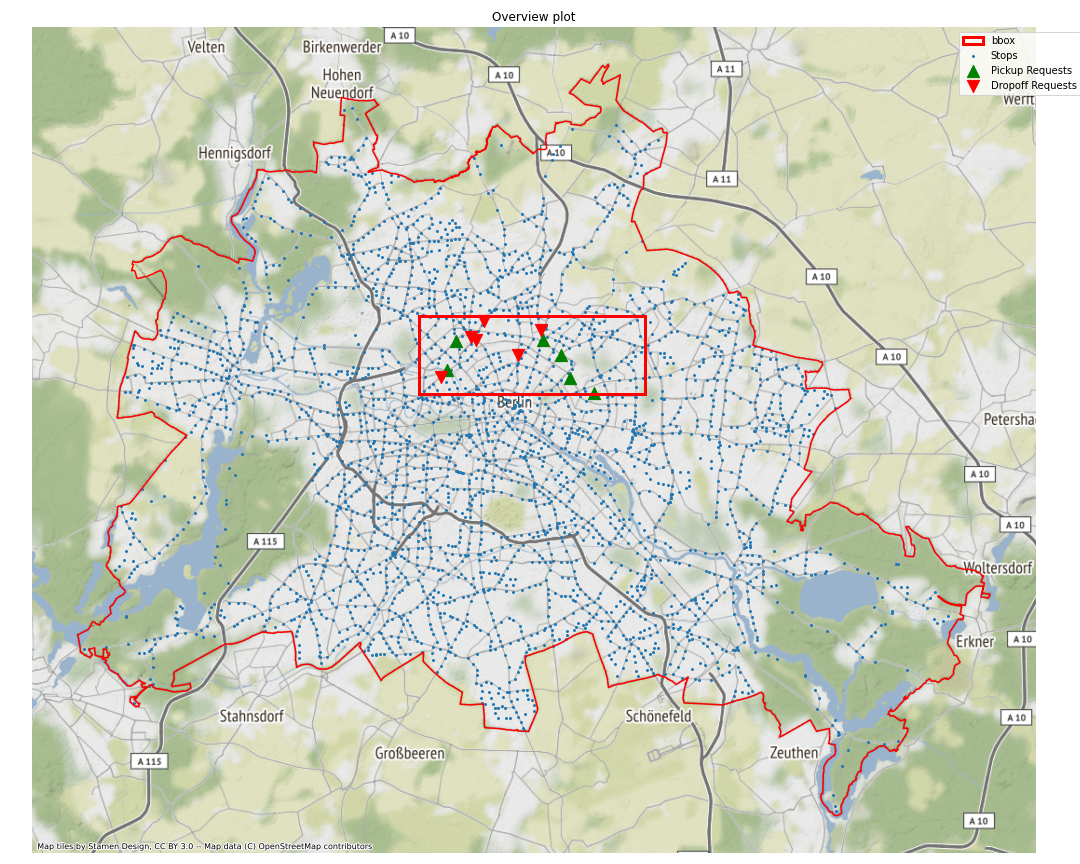

In [13]:
visualiser.generate_overview_figure()
img = Image.open(f'{visualiser.static_path}/{visualiser.id}_overview_plot.png')
img

### visualiser.generate_closeup_figure()

A closeup image can be generated using the `Visualiser.generate_closeup_figure()` function. Once again the figure is stored in the `visualiser.static_path` directory.

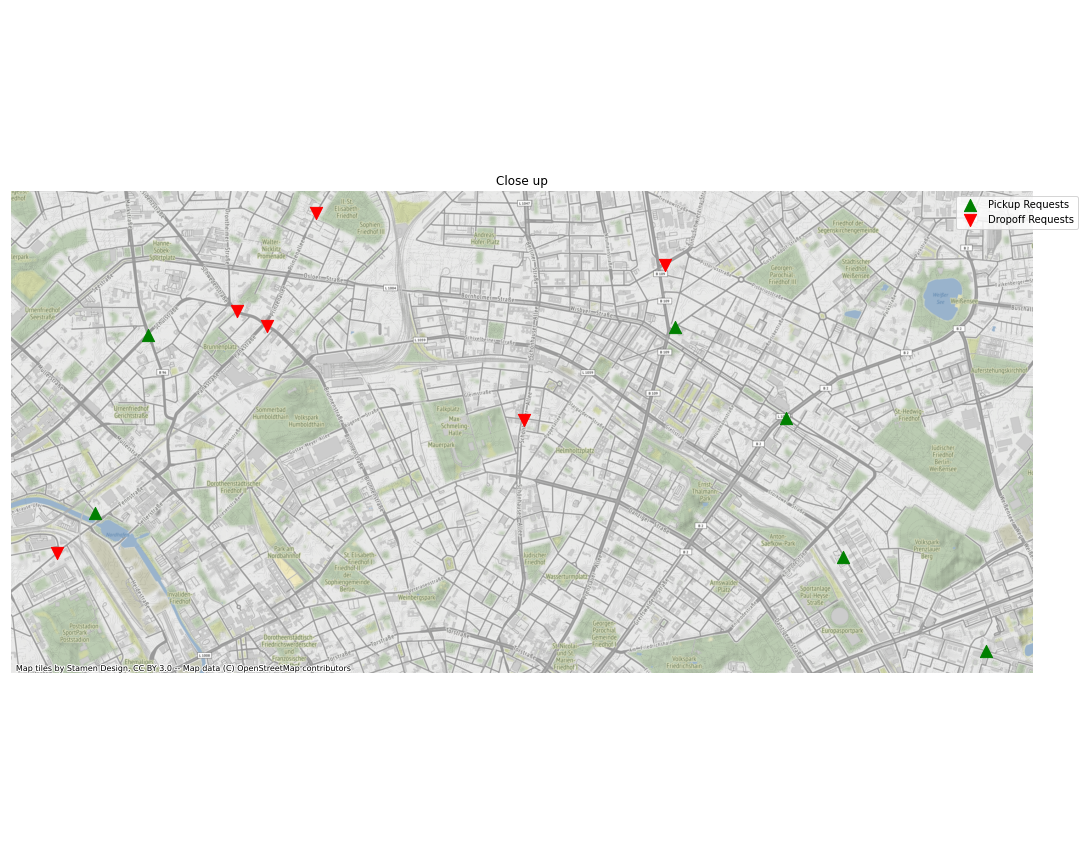

In [14]:
visualiser.generate_closeup_figure()

img = Image.open(f'{visualiser.static_path}/{visualiser.id}_closeup_plot.png')
img

### visualiser.generate_gmap()

The module [gmplot](https://pypi.org/project/gmplot/) is used to facilitate map plotting. The result is an interactive HTML map. The output map can be found in the `visualiser.static_path` directory, which in this notebook is: 

In [23]:
print(visualiser.static_path)

/home/floris/coding/home_projects/door2door_mi_challenge/webapp/static


In [24]:
visualiser.generate_gmap()

# The webapp module

The webapp module contains the web interface. 
All of the webpages are generated using the python `flask` module. 

Two directories are necessary: 
- a `templates` directory to store the visualisation templates used to generate HTML. In this directory I have created four files: `layout.html` containing the essential layout (bootstrap) + a code block which we extend in the other pages. `home.html` is the landing page for the application. It contains a form that can be used to trigger a simulation & visualisation. `visualisation.html` is the visualisation page that loads the three visualisations and shows a button to perform a new simulation. A helper jinja file is given in `_macros.jinja` to facilitate generation of form elements. 
- a `static` directory to store the generated images / maps. 

Some other files are present: 

- an `__init__.py` file to instantiate the module. This file creates the python flask application according to the [application factory](https://flask.palletsprojects.com/en/1.1.x/patterns/appfactories/) standard. This is mainly used to easily extend a webapp with new functionality.
- a `config.py` file containing the config of the web app. These are mostly paths and other configuration requirements. We use a csrf token to allow for form submission in the html page.
- a `forms.py` file containing the web form that is shown as a homepage when running the app. This form data can be altered by the user. A test is made to assert that the fields are of correct data type and filled.
- a `routes.py` file containing the required routing points for the webapp. In essence only two routes are necessary: a `trigger_page` route to initialize the simulation and generate the resulting images, and a `visualise` route to visualise  the newly made results. 
